<center> <h1>Analysis of Yelp Business Intelligence Data</h1> </center>

In this project, I analyzed a subset of the Yelp's business, reviews and user data.<br/> 

The dataset originally comes from [Kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset) and it has been uploaded into an S3 bucket: <br/>

s3://yelpreviewdataset/yelp_academic_dataset_business.json\
s3://yelpreviewdataset/yelp_academic_dataset_review.json\
s3://yelpreviewdataset/yelp_academic_dataset_user.json

## Part I: Installation and Initial Setup

### 1. Install Packages

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession \
.builder \
.appName("Analysis of Yelp Business") \
.config("spark.some.config.option", "some-value") \
.getOrCreate()
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("seaborn==0.10.0")
sc.list_packages()

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1606187319027_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…




Package                    Version  
-------------------------- ---------
beautifulsoup4             4.9.1    
boto                       2.49.0   
click                      7.1.2    
cycler                     0.10.0   
jmespath                   0.10.0   
joblib                     0.16.0   
kiwisolver                 1.3.1    
lxml                       4.5.2    
matplotlib                 3.2.1    
mysqlclient                1.4.2    
nltk                       3.5      
nose                       1.3.4    
numpy                      1.16.5   
pandas                     1.0.3    
pip                        9.0.1    
py-dateutil                2.2      
pyparsing                  2.4.7    
python-dateutil            2.8.1    
python37-sagemaker-pyspark 1.4.0    
pytz                       2020.1   
PyYAML                     5.3.1    
regex                      2020.7.14
scipy                      1.5.4    
seaborn                    0.10.0   
setuptools                 28.8.0  

### 2. Importing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.sql.functions as F
from scipy import stats
from scipy.stats import norm, skew
from pyspark.sql.functions import explode, split, desc, col, avg, udf, when
from pyspark.sql.types import IntegerType, StringType, DoubleType

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 3. Loading Data

In [3]:
business_df = spark.read.json('s3://yelpreviewdataset/yelp_academic_dataset_business.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 4. Overview of Data

In [4]:
print(f'Columns: {len(business_df.columns)} | Rows: {business_df.count():,}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Columns: 14 | Rows: 209,393

In [5]:
business_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Display the first 5 rows with the following columns:

- business_id
- name
- city
- state
- categories

In [6]:
busi_df = business_df.select('business_id', 'name', 'city', 'state', 'stars', 'categories')
busi_df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------------+-----+-----+--------------------+
|         business_id|                name|           city|state|stars|          categories|
+--------------------+--------------------+---------------+-----+-----+--------------------+
|f9NumwFMBDn751xgF...|The Range At Lake...|      Cornelius|   NC|  3.5|Active Life, Gun/...|
|Yzvjg0SayhoZgCljU...|   Carlos Santo, NMD|     Scottsdale|   AZ|  5.0|Health & Medical,...|
|XNoUzKckATkOD1hP6...|             Felinus|       Montreal|   QC|  5.0|Pets, Pet Service...|
|6OAZjbxqM5ol29BuH...|Nevada House of Hose|North Las Vegas|   NV|  2.5|Hardware Stores, ...|
|51M2Kk903DFYI6gnB...|USE MY GUY SERVIC...|           Mesa|   AZ|  4.5|Home Services, Pl...|
+--------------------+--------------------+---------------+-----+-----+--------------------+
only showing top 5 rows

## Part II: Analyzing Categories

Let's now answer: **How many unique categories are represented in this dataset?**

Essentially, we have the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer the following questions such as:

- How many businesses are categorized as Active Life？
- What are the top 20 most popular categories available?

### 1. Association Table 
We need to "break out" these categories from the business ids? One common approach to take is to build an association table mapping a single business id multiple times to each distinct category.

For instance, given the following:

| business_id |	categories |
|:------------|:-----------|
| abcd123     | a,b,c      |


We would like to derive something like:

| business_id |	category |
|:------------|:---------|
| abcd123     | a        |
| abcd123	  | b        |
| abcd123	  | c        |


What this does is allow us to then perform a myriad of rollups and other analysis on this association table which can aid us in answering the questions asked above.

Display the first 5 rows of the association table below

In [7]:
associ_table_one = business_df.select('business_id', explode(split(business_df.categories, ', ')).alias('category'))
associ_table_one.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------------+
|         business_id|        category|
+--------------------+----------------+
|f9NumwFMBDn751xgF...|     Active Life|
|f9NumwFMBDn751xgF...|Gun/Rifle Ranges|
|f9NumwFMBDn751xgF...|     Guns & Ammo|
|f9NumwFMBDn751xgF...|        Shopping|
|Yzvjg0SayhoZgCljU...|Health & Medical|
+--------------------+----------------+
only showing top 5 rows

### 2. Total Unique Categories

Finally, we are ready to answer the question: **what is the total number of unique categories available?**

In [8]:
associ_table_one.select('category').distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1336

### 3. Top Categories By Business
Now let's find the top categories in this dataset by rolling up categories.
#### Counts of Businesses / Category

In [9]:
category_count = associ_table_one.select('category').groupby(associ_table_one.category).count()
category_count.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|            category|count|
+--------------------+-----+
|      Paddleboarding|   36|
|      Dermatologists|  341|
|        Aerial Tours|   28|
|         Hobby Shops|  828|
|          Bubble Tea|  720|
|             Embassy|   13|
|             Tanning|  938|
|            Handyman|  682|
|      Aerial Fitness|   29|
|             Falafel|  159|
|       Outlet Stores|  399|
|        Summer Camps|  318|
|     Clothing Rental|   55|
|      Sporting Goods| 2311|
|     Cooking Schools|  118|
|  College Counseling|   15|
|  Lactation Services|   50|
|Ski & Snowboard S...|   50|
|             Museums|  359|
|              Doulas|   45|
+--------------------+-----+
only showing top 20 rows

#### Bar Chart of Top Categories
With this data available, let us now build a barchart of the top 20 categories

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

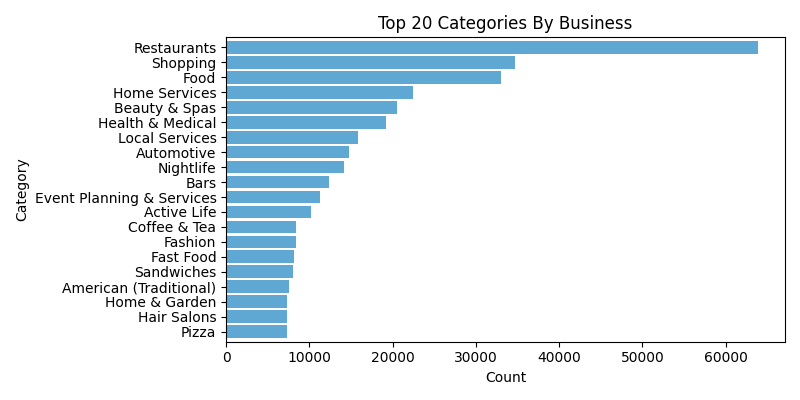

In [52]:
top_20 = category_count.sort(desc('count')).limit(20).toPandas()

ax = top_20.plot(kind='barh', x='category', y='count', 
            figsize=(8, 4), color='#5fa8d3', zorder=2, width=0.85)

ax.invert_yaxis()
ax.set_xlabel("Count")
ax.set_ylabel("Category")
ax.set_title("Top 20 Categories By Business")
ax.get_legend().remove()

plt.tight_layout()
%matplot plt

## Part III. Do Yelp Reviews Skew Negative?
Oftentimes, it is said that the only people who write a written review are those who are extremely dissatisfied or extremely satisfied with the service received.

How true is this really? Let's try and answer this question.

### 1. Loading Review Data

Begin by loading the review data set from S3 and printing schema to determine what data is available

In [11]:
review_df = spark.read.json('s3://yelpreviewdataset/yelp_academic_dataset_review.json')
review_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

Let's begin by listing the business_id and stars columns together for the user reviews data

In [12]:
business_stars = review_df.select('business_id', 'stars')
business_stars.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|-MhfebM0QIsKt87iD...|  2.0|
|lbrU8StCq3yDfr-QM...|  1.0|
|HQl28KMwrEKHqhFrr...|  5.0|
|5JxlZaqCnk1MnbgRi...|  1.0|
|IS4cv902ykd8wj1TR...|  4.0|
+--------------------+-----+
only showing top 5 rows

Now, let's aggregate along the stars column to get a resultant dataframe that displays average stars per business as accumulated by users who **took the time to submit a written review**

In [13]:
written_review = review_df.where(col("text").isNotNull()).groupby(review_df.business_id).agg(avg(col("stars")))
written_review.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|        avg(stars)|
+--------------------+------------------+
|RMjCnixEY5i12Ciqn...|3.5316455696202533|
|VHsNB3pdGVcRgs6C3...| 3.411764705882353|
|kpbhERZoj1eTDRnMV...| 2.033333333333333|
|ipFreSFhjClfNETuM...|               2.6|
|9A_mB7Ez3RIh26EN5...|               2.6|
+--------------------+------------------+
only showing top 5 rows

Now the fun part - let's join our two dataframes (reviews and business data) by business_id

In [14]:
user_review = review_df.groupby(review_df.business_id).agg(avg(col("stars")))
new_df1 = business_df.join(written_review, on=['business_id'])
new_df2= business_df.join(user_review,on=['business_id'])
new_df1.select("""avg(stars)""","stars","name","city","state").sort(desc("""avg(stars)""")).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+--------------------+----------+-----+
|avg(stars)|stars|                name|      city|state|
+----------+-----+--------------------+----------+-----+
|       5.0|  5.0|  Larry Fafalak, LMT| Las Vegas|   NV|
|       5.0|  5.0|   Rentech Solutions|Willoughby|   OH|
|       5.0|  5.0|Everest Curry and...|   Calgary|   AB|
|       5.0|  5.0|Krown Rust Contro...|   Markham|   ON|
|       5.0|  5.0|     EVO Swim School|      Mesa|   AZ|
+----------+-----+--------------------+----------+-----+
only showing top 5 rows

Compute a new dataframe that calculates what we will call the skew (for lack of a better word) between the avg stars accumulated from written reviews and the actual star rating of a business (ie: the average of stars given by reviewers who wrote an actual review and reviewers who just provided a star rating).

The formula you can use is something like:

(row['avg(stars)'] - row['stars']) / row['stars']

If the **skew** is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If **skew** is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [15]:
fv_df1 = new_df1.select("avg(stars)","stars","name","city","state").sort("""avg(stars)""",ascending=False)
fv_df2 =   new_df2.select("avg(stars)","stars","name","city","state").sort("""avg(stars)""",ascending=False)
fv_df = fv_df1.withColumn("skew", ((fv_df1["""avg(stars)"""]-fv_df2["stars"])/fv_df1["stars"])).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

And finally, graph it!

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

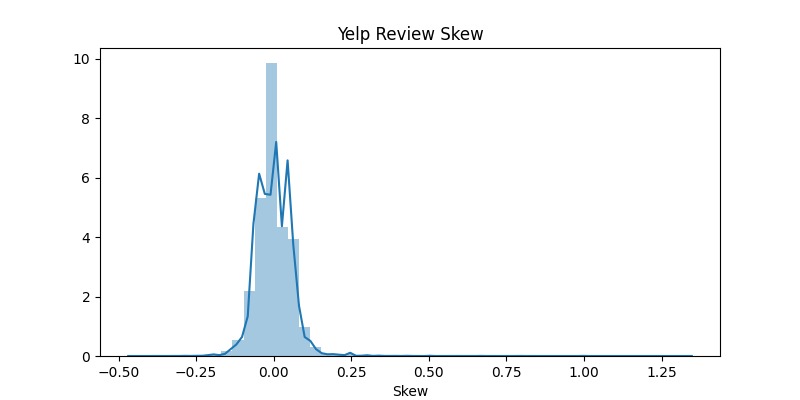

In [50]:
plt.figure(figsize=(8,4))
ax = sns.distplot(fv_df["skew"])
ax.set_xlabel('Skew')
plt.title("Yelp Review Skew")

%matplot plt

So, do Yelp (written) Reviews skew negative? Does this analysis actually prove anything? Expound on implications / interpretations of this graph.

The distribution of skew appears to be normal, but skewed a little bit to the right. The implications of the above graph are that the satisfaction level of reviewers who left positively skewed reviews is greater than the dissatisfaction level of reviewers who left negatively skewed reviews.

## Part IV. Should the Elite be Trusted? 
How accurate or close are the ratings of an "elite" user (check Users table schema) vs the actual business rating

It takes a special Yelper to become an Elite. Frequent, quality reviews and photos are important in the application of the elite status on Yelp. Elite candidates need to meet the criteria below for the consideration. 

To become Elite, Yelpers agree that they

- Are using their real name on Yelp.
- Have a clear photo of themself on their profile page.
- Are of legal drinking age where they live.

They also agree that they are NOT
- A business owner.
- Closely affiliated with a business owner. 
- Managing a Yelp Business Account.
- Working for one of Yelp's competitors.

It's important to know that accepting compensation or freebies in exchange for reviews or leveraging the Elite Squad for personal or commercial gain will result in Elite status being revoked or account closure.

### 1. Loading User Data

In [17]:
user_df = spark.read.json('s3://yelpreviewdataset/yelp_academic_dataset_user.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 2. Overview of Data

In [18]:
user_df.printSchema()
print(f'User Dataset Columns: {len(user_df.columns)} | Rows: {user_df.count():,}')
review_df.printSchema()
print(f'Review Dataset Columns: {len(review_df.columns)} | Rows: {review_df.count():,}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

User Dataset Columns: 22 | Rows: 1,968,703
root
 |-- business_id: str

In [19]:
user_df.select('user_id','elite').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|             user_id|               elite|
+--------------------+--------------------+
|ntlvfPzc8eglqvk92...|                    |
|FOBRPlBHa3WPHFB5q...|2008,2009,2010,20...|
|zZUnPeh2hEp0WydbA...|                2010|
|QaELAmRcDc5TfJEyl...|                2009|
|xvu8G900tezTzbbfq...|2009,2010,2011,20...|
+--------------------+--------------------+
only showing top 5 rows

### 3. Split Elite column

In [20]:
user_elite_split = user_df.select('user_id', explode(split(user_df.elite, ',')).alias('elite'))
user_elite_split = user_elite_split.withColumn('elite', user_elite_split.elite.cast(IntegerType()))
user_elite_split.show(5)
print(f'User Elite Split Dataset Columns: {len(user_elite_split.columns)} | Rows: {user_elite_split.count():,}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|             user_id|elite|
+--------------------+-----+
|ntlvfPzc8eglqvk92...| null|
|FOBRPlBHa3WPHFB5q...| 2008|
|FOBRPlBHa3WPHFB5q...| 2009|
|FOBRPlBHa3WPHFB5q...| 2010|
|FOBRPlBHa3WPHFB5q...| 2011|
+--------------------+-----+
only showing top 5 rows

User Elite Split Dataset Columns: 2 | Rows: 2,125,315

In [21]:
user_elite_split.select("elite").distinct().sort('elite', ascending=False).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+
|elite|
+-----+
| 2018|
| 2017|
| 2016|
| 2015|
| 2014|
| 2013|
| 2012|
| 2011|
| 2010|
| 2009|
| 2008|
| 2007|
| 2006|
| null|
+-----+

In [22]:
Elite_or_Not = user_elite_split.select('user_id',
           when( user_elite_split.elite.isNull(), "Not Elite").otherwise("Elite").alias('Elite or Not'))
Elite_or_Not.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+
|             user_id|Elite or Not|
+--------------------+------------+
|ntlvfPzc8eglqvk92...|   Not Elite|
|FOBRPlBHa3WPHFB5q...|       Elite|
|FOBRPlBHa3WPHFB5q...|       Elite|
|FOBRPlBHa3WPHFB5q...|       Elite|
|FOBRPlBHa3WPHFB5q...|       Elite|
|FOBRPlBHa3WPHFB5q...|       Elite|
|FOBRPlBHa3WPHFB5q...|       Elite|
|zZUnPeh2hEp0WydbA...|       Elite|
|QaELAmRcDc5TfJEyl...|       Elite|
|xvu8G900tezTzbbfq...|       Elite|
|xvu8G900tezTzbbfq...|       Elite|
|xvu8G900tezTzbbfq...|       Elite|
|xvu8G900tezTzbbfq...|       Elite|
|xvu8G900tezTzbbfq...|       Elite|
|xvu8G900tezTzbbfq...|       Elite|
|xvu8G900tezTzbbfq...|       Elite|
|xvu8G900tezTzbbfq...|       Elite|
|xvu8G900tezTzbbfq...|       Elite|
|z5_82komKV3mI4ASG...|       Elite|
|ttumcu6hWshk_EJVW...|   Not Elite|
+--------------------+------------+
only showing top 20 rows

In [23]:
unique_user_df = Elite_or_Not.dropDuplicates(['user_id'])
unique_user_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+
|             user_id|Elite or Not|
+--------------------+------------+
|---RfKzBwQ8t3wu-L...|   Not Elite|
|--1UpCuUDJQbqiuFX...|   Not Elite|
|--AGAPpP1pgp1afbq...|   Not Elite|
|--C-42rr7hPSsUROJ...|   Not Elite|
|--ChzqcPs4YFWlw1j...|   Not Elite|
|--ET3paBtrThD95dk...|   Not Elite|
|--GLTFzU93A40YB56...|   Not Elite|
|--I4wRDhmM2J2VLzK...|   Not Elite|
|--RquisWmBzcezXZr...|   Not Elite|
|--UizzbnQlZg7bEv2...|   Not Elite|
|--cd_gA-9Q8gM9P2c...|   Not Elite|
|--dhSVoOFDBiMCCwD...|   Not Elite|
|--fpTdHQOGWGbAjk9...|   Not Elite|
|--ju6XpRd0dY1Swmf...|   Not Elite|
|--oVdTxVd7QVr8Y0U...|   Not Elite|
|--pWqE-KOwDWo5ADG...|   Not Elite|
|--t6W1JHbStaCp5RO...|   Not Elite|
|--tmwndDOZJwfRvvt...|   Not Elite|
|--yrdC1dIR6VYsW6k...|   Not Elite|
|-06viLTmtlRTHxxDg...|   Not Elite|
+--------------------+------------+
only showing top 20 rows

### 4. Join "Unique User" Dataset with Review Dataset

In [24]:
user_join_review = review_df.join(unique_user_df, on = "user_id", how='left')
print(f'User Join Review Dataset Columns: {len(user_join_review.columns)} | Rows: {user_join_review.count():,}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

User Join Review Dataset Columns: 10 | Rows: 8,021,122

### 5. Clean Data

Combined Dateset which includes elite and non-elite

In [25]:
combine_df = user_join_review.select('review_id','business_id','stars','user_id','Elite or Not')
combine_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-----+--------------------+------------+
|           review_id|         business_id|stars|             user_id|Elite or Not|
+--------------------+--------------------+-----+--------------------+------------+
|rv2EaVEP_cs0Yzc-z...|Z3ZSar8IVAR2qIupq...|  5.0|---RfKzBwQ8t3wu-L...|   Not Elite|
|HVR4EWzZMlyPrdbzE...|kJhQq1BFz7lOYLve7...|  1.0|--1UpCuUDJQbqiuFX...|   Not Elite|
|uy83M2YEnInksqsKX...|EpPOZAG0u7qHP-jv5...|  5.0|--1UpCuUDJQbqiuFX...|   Not Elite|
|EHsBHPADGfllO2Zm5...|OLmcIJ7VBCxaYhZSN...|  5.0|--AGAPpP1pgp1afbq...|   Not Elite|
|xtHcnwOx-27sunclu...|WoiOpMEcbAfOqNYXq...|  5.0|--AGAPpP1pgp1afbq...|   Not Elite|
|pFq8ijDeB-Gz1HXsS...|L-_-9JNAb6UDyq7wa...|  4.0|--C-42rr7hPSsUROJ...|   Not Elite|
|SI_ONkbwzN_i38Gvg...|4KmrrhtfnngTVFa2d...|  4.0|--ChzqcPs4YFWlw1j...|   Not Elite|
|fHqAyF58eC6vC4_BP...|AMTNJbYbu0OMMAkx4...|  4.0|--ChzqcPs4YFWlw1j...|   Not Elite|
|bQkvjkpLZmtFYaYdO...|KVsv8wRGnLX8QWoNZ...|  3.0|--ChzqcPs4YFWlw1j...|   Not

Combined (Elite and Non-Elite) Average Ratings Grouped by Business ID

In [26]:
combine_stars_df = combine_df.groupBy("business_id").agg(F.mean('stars').alias('Stars'))
combine_stars_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|             Stars|
+--------------------+------------------+
|--9e1ONYQuAa-CB_R...|  4.11784140969163|
|RtUvSWO_UZ8V3Wpj0...| 4.133498145859085|
|kpbhERZoj1eTDRnMV...| 2.033333333333333|
|eKznX8VTfcQrjCqXp...|4.3584905660377355|
|umwULmdsxx8aTsoRQ...| 2.388888888888889|
|ru_WUOAmx9xPBxcJu...|               5.0|
|VHsNB3pdGVcRgs6C3...| 3.411764705882353|
|rtwojGcYuhbLbQ9D1...|3.4545454545454546|
|SjgeuBlgKER9yegpo...| 3.973643410852713|
|VmSrPPO2WXmOKjUW7...| 3.227906976744186|
|0FWYa5RT_gQOwW3CR...|3.4545454545454546|
|RMjCnixEY5i12Ciqn...|3.5316455696202533|
|llCxryWr8j1S39tus...|  4.43839541547278|
|35X1ZV9tSEqB__yJE...|3.0316742081447963|
|X6jKCn5FoRiJ1t7y4...|1.8444444444444446|
|DgCAM01n2Qo5DsoKj...|3.3448275862068964|
|xusE_x84QOEDaRZ8r...|3.7096774193548385|
|cz5vz-893D3LNH3TM...| 3.803514376996805|
|jfdUtdkXogP2kjK5K...|3.6323529411764706|
|uC3qwaxsOkdJzpOc0...| 3.368948247078464|
+--------------------+------------

Elite Only Dataset

In [27]:
elite_df = combine_df.filter(col("Elite or Not") == "Elite")  
elite_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-----+--------------------+------------+
|           review_id|         business_id|stars|             user_id|Elite or Not|
+--------------------+--------------------+-----+--------------------+------------+
|EIKPUavToyh-dz2eE...|WYw3Uf56DT5IwpaLN...|  5.0|-1_RJoRLeoDK3h_gN...|       Elite|
|ygfb-2RWSKtI3jVC3...|0gXYLVPNWz0WT8wXQ...|  4.0|-1_RJoRLeoDK3h_gN...|       Elite|
|84GE9SrQCw-Yv-qpM...|W2CzAePJakvARgoQu...|  3.0|-1_RJoRLeoDK3h_gN...|       Elite|
|tyTkxTaNh1sL8t9XK...|iCQpiavjjPzJ5_3gP...|  4.0|-1_RJoRLeoDK3h_gN...|       Elite|
|TJDpUewi8F1E9eUgi...|qalkZ4AQDWzYrFvQV...|  5.0|-1_RJoRLeoDK3h_gN...|       Elite|
|bAd_-cPcZNsVfhFgN...|_w5hBpkjHs5_Hv3pL...|  4.0|-1_RJoRLeoDK3h_gN...|       Elite|
|kKuzCM7kpGqCUe3iD...|Yl05MqCs9xRzrJFkG...|  5.0|-1_RJoRLeoDK3h_gN...|       Elite|
|ITIUKGvnRE3u6RLns...|7FvDsYqtij_BbaGVt...|  3.0|-1_RJoRLeoDK3h_gN...|       Elite|
|W4FCaD23_CzAoC28j...|A4zLP5AyKEEHQr_dW...|  4.0|-1_RJoRLeoDK3h_gN...|      

Elite Average Rating Grouped by Business ID

In [28]:
elite_stars_df = elite_df.groupBy("business_id").agg(F.mean('stars').alias('Stars rated by elite'))
elite_stars_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|         business_id|Stars rated by elite|
+--------------------+--------------------+
|eKznX8VTfcQrjCqXp...|   4.268817204301075|
|RtUvSWO_UZ8V3Wpj0...|   4.156193895870736|
|rtwojGcYuhbLbQ9D1...|  3.3636363636363638|
|--9e1ONYQuAa-CB_R...|  4.1916058394160585|
|X6jKCn5FoRiJ1t7y4...|                 4.5|
|SjgeuBlgKER9yegpo...|  3.8938775510204082|
|jfdUtdkXogP2kjK5K...|  3.3846153846153846|
|uC3qwaxsOkdJzpOc0...|  3.6745562130177514|
|yJGr28OXuMk2bCKYl...|               3.125|
|f4mh1Y0rnvbJRfQ3j...|               3.875|
|cz5vz-893D3LNH3TM...|  3.8587570621468927|
|MEoDTsA3Af6TLzB7Z...|  3.2142857142857144|
|qtsrM6Xxh1LqxG0X6...|                 4.5|
|OjuzFQpprqmuapKh6...|                 3.6|
|VmSrPPO2WXmOKjUW7...|   3.423076923076923|
|Rxb7oKtKyDUwuFNc2...|  3.4285714285714284|
|4iY_gyKX2ogbem7ra...|   4.444444444444445|
|mx0Pjm0erpv1CqsRI...|                 3.8|
|VHsNB3pdGVcRgs6C3...|                 4.0|
|LCRdP3m826-Df52-x...|          

Non-Elite Dataset

In [29]:
non_elite_df = combine_df.filter(col("Elite or Not") == "Not Elite")  
non_elite_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-----+--------------------+------------+
|           review_id|         business_id|stars|             user_id|Elite or Not|
+--------------------+--------------------+-----+--------------------+------------+
|rv2EaVEP_cs0Yzc-z...|Z3ZSar8IVAR2qIupq...|  5.0|---RfKzBwQ8t3wu-L...|   Not Elite|
|HVR4EWzZMlyPrdbzE...|kJhQq1BFz7lOYLve7...|  1.0|--1UpCuUDJQbqiuFX...|   Not Elite|
|uy83M2YEnInksqsKX...|EpPOZAG0u7qHP-jv5...|  5.0|--1UpCuUDJQbqiuFX...|   Not Elite|
|EHsBHPADGfllO2Zm5...|OLmcIJ7VBCxaYhZSN...|  5.0|--AGAPpP1pgp1afbq...|   Not Elite|
|xtHcnwOx-27sunclu...|WoiOpMEcbAfOqNYXq...|  5.0|--AGAPpP1pgp1afbq...|   Not Elite|
|pFq8ijDeB-Gz1HXsS...|L-_-9JNAb6UDyq7wa...|  4.0|--C-42rr7hPSsUROJ...|   Not Elite|
|V4nVpftxljW4sFOgO...|6pG7n8Rx_7ZXeQQk6...|  2.0|--ChzqcPs4YFWlw1j...|   Not Elite|
|fHqAyF58eC6vC4_BP...|AMTNJbYbu0OMMAkx4...|  4.0|--ChzqcPs4YFWlw1j...|   Not Elite|
|YSW-S2XUyCKR3jUtW...|F9CcIFltPDXiOkCCF...|  4.0|--ChzqcPs4YFWlw1j...|   Not

Non-Elite Average Rating Grouped by Business ID

In [30]:
non_elite_stars_df = non_elite_df.groupBy("business_id").agg(F.mean('stars').alias('Stars rated by non elite'))
non_elite_stars_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------------+
|         business_id|Stars rated by non elite|
+--------------------+------------------------+
|--9e1ONYQuAa-CB_R...|        4.08596214511041|
|RtUvSWO_UZ8V3Wpj0...|       4.121583411875589|
|kpbhERZoj1eTDRnMV...|      1.9642857142857142|
|umwULmdsxx8aTsoRQ...|                    2.25|
|ru_WUOAmx9xPBxcJu...|                     5.0|
|VHsNB3pdGVcRgs6C3...|       3.279279279279279|
|eKznX8VTfcQrjCqXp...|       4.406976744186046|
|SjgeuBlgKER9yegpo...|                  4.0225|
|VmSrPPO2WXmOKjUW7...|       3.201058201058201|
|0FWYa5RT_gQOwW3CR...|                     3.4|
|RMjCnixEY5i12Ciqn...|      3.6226415094339623|
|llCxryWr8j1S39tus...|      4.4627831715210355|
|35X1ZV9tSEqB__yJE...|      3.0080645161290325|
|X6jKCn5FoRiJ1t7y4...|      1.7209302325581395|
|DgCAM01n2Qo5DsoKj...|      3.1739130434782608|
|xusE_x84QOEDaRZ8r...|      3.7142857142857144|
|cz5vz-893D3LNH3TM...|      3.7817371937639197|
|uC3qwaxsOkdJzpOc0...|      3.2488372093

Prepare data for plotting

In [31]:
combined_data = combine_stars_df.toPandas()["Stars"].values.tolist()
elite_data = elite_stars_df.toPandas()["Stars rated by elite"].values.tolist()
non_elite_data = non_elite_stars_df.toPandas()["Stars rated by non elite"].values.tolist()
data = [combined_data, elite_data, non_elite_data]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

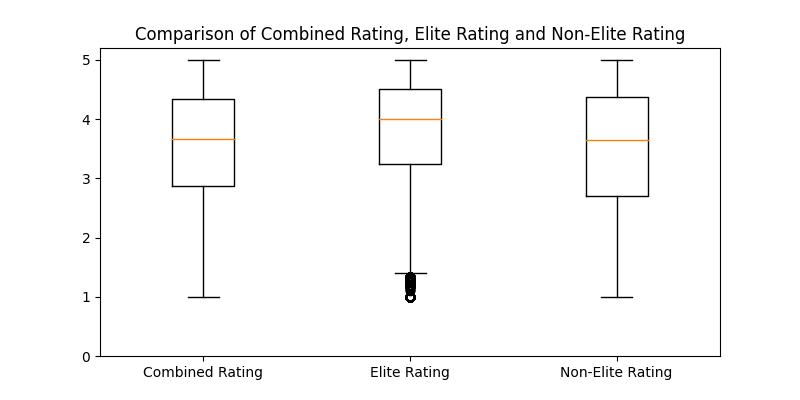

In [49]:
fig = plt.figure(figsize =(8, 4)) 
plt.boxplot(data)
plt.xticks([1, 2, 3], ['Combined Rating', 'Elite Rating', 'Non-Elite Rating'])
plt.title("Comparison of Combined Rating, Elite Rating and Non-Elite Rating")
y_ticks = np.arange(0, 6, 1)
plt.yticks(y_ticks)
plt.show() 
%matplot plt

As we can see from the above boxplot, elite data has more outliers. Additionally, the first, third quantiles and the median of the elite ratings are also higher than the non-elites' ratings. From my point of view, I would say elite should not be trusted.

## Part V. Recommended Restaurants

In [77]:
busi_eda = business_df.select('business_id', 'name', 'city', 'stars', 'review_count', 'address', 'categories', 'latitude', 'longitude') 
restaurants_df = busi_eda.where(col('categories').like("%Restaurants%"))
restaurants_5_stars = restaurants_df.filter(col("stars") == 5)
restaurants_5_stars_many_reviews = restaurants_5_stars.filter(col("review_count") > 100)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [87]:
wow_restaurant_df = restaurants_5_stars_many_reviews.select('name', 'city', 'review_count','address','categories','latitude', 'longitude')
wow_restaurant_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------+------------+--------------------+--------------------+-------------+---------------+
|                name|      city|review_count|             address|          categories|     latitude|      longitude|
+--------------------+----------+------------+--------------------+--------------------+-------------+---------------+
|           Chili Man| Charlotte|         172|             S Tryon|Hot Dogs, Food, S...|    35.226911|     -80.843823|
|Los Olivos Ristor...| Las Vegas|         222|3759 E Desert Inn Rd|Restaurants, Italian|   36.1291778|   -115.0924833|
|      The Real Crepe| Las Vegas|         205|7595 W Washington...|Creperies, Restau...|   36.1810984|   -115.2592634|
|          Sojo Ramen| Las Vegas|         202|7377 S Jones Blvd...|Ramen, Japanese, ...|36.0552179707|-115.2259209752|
|Oliver's Sophisti...|   Phoenix|         101|333 E Roosevelt S...|Coffee & Tea, Org...|   33.4584453|   -112.0694742|
|    Simon's Hot Dogs|Scottsdale|         457|42